<a href="https://colab.research.google.com/github/epigos/learning-pytorch/blob/master/notebooks/06_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from collections import defaultdict, deque
import math
import time
import copy
import itertools
import warnings
from datetime import datetime
import os
warnings.filterwarnings('ignore')

import numpy as np

import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
import torchvision.models as models

from PIL import Image, ImageFile
import matplotlib.pyplot as plt

ImageFile.LOAD_TRUNCATED_IMAGES=True

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available(): print('Device name:', torch.cuda.get_device_name())

Device name: Tesla K80


In [0]:
number_epochs = 10
batch_size = 128
learning_rate = 1e-4

# Load data

In [4]:
transform_image = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = MNIST('../dataset/', transform=transform_image, download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Extracting ../dataset/MNIST/raw/train-images-idx3-ubyte.gz to ../dataset/MNIST/raw


Extracting ../dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ../dataset/MNIST/raw


Extracting ../dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ../dataset/MNIST/raw


Extracting ../dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../dataset/MNIST/raw
Processing...
Done!


In [5]:
print(f"Number of training images: {len(dataset)}")
print(f"Size of each image: {dataset[0][0].size()}")

Number of training images: 60000
Size of each image: torch.Size([1, 28, 28])


## show some images

In [6]:
def imshow(tensor, ax=None):
    np_img = tensor.permute(1, 2, 0)
    if not ax:
        _, ax = plt.subplots()
    ax.imshow(np_img)
    plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


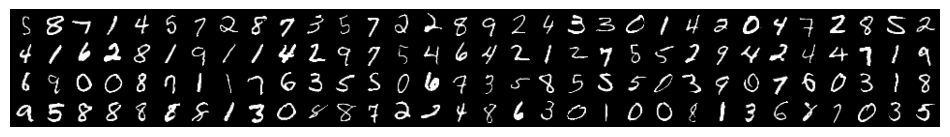

In [7]:
# get some random training images
data_iter = iter(data_loader)
sample_images, labels = data_iter.next()
# show images
fig, ax = plt.subplots(figsize=(12, 4), dpi=100)
grid = torchvision.utils.make_grid(sample_images, nrow=int(batch_size/4))
imshow(grid, ax=ax)

# Create MLP AutoEncoder model

In [0]:
class AutoEncoder(nn.Module):
    
    def __init__(self, input_size=28, hidden_size=3):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_size * input_size, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 12),
            nn.ReLU(True),
            nn.Linear(12, hidden_size),
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), 
            nn.Linear(128, input_size * input_size), 
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x    

In [9]:
ae = AutoEncoder()
ae

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=12, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Tanh()
  )
)

In [10]:
# test model
ae(torch.rand(1, 1, 28 * 28))

tensor([[[-3.9947e-02,  3.8525e-02, -1.3869e-02,  1.0080e-01, -6.9046e-03,
          -8.2170e-02, -1.0925e-01,  5.6071e-02,  2.7668e-03, -4.4267e-02,
          -5.3824e-03, -8.6851e-02,  3.1962e-02,  5.1849e-02, -8.0359e-02,
          -5.6523e-02, -5.9877e-02,  8.0815e-02, -2.6676e-03, -6.4382e-02,
          -3.3939e-02, -5.9345e-02, -6.9989e-02,  4.1567e-02,  1.0419e-01,
          -2.1577e-02, -7.3050e-02,  2.4841e-02,  6.0951e-02,  8.9525e-02,
          -2.4693e-02,  9.7498e-02, -6.1029e-02, -6.8443e-02,  4.3264e-02,
          -2.2317e-02, -4.4989e-02, -2.3005e-02,  6.5733e-02,  1.1068e-02,
          -1.0214e-01, -8.4419e-02, -1.1001e-01, -2.0181e-02,  8.0177e-02,
          -1.1476e-01, -5.0920e-02, -5.2565e-02, -1.5087e-01, -7.3812e-02,
           4.4412e-02,  1.2897e-02,  6.0179e-02, -1.2579e-01,  1.4618e-02,
           7.5985e-02,  1.5584e-02, -4.0926e-02,  1.9356e-02,  4.5674e-02,
          -2.7232e-02,  9.6966e-02,  1.1437e-02,  1.7424e-01, -1.5996e-01,
           3.7328e-02, -3

In [0]:
def to_image(x):
    """Convert model output to image"""
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x


def imshow_tensor(inputs):
    grid = torchvision.utils.make_grid(inputs, normalize=True, scale_each=True, nrow=int(batch_size/4))
    fig, ax = plt.subplots(figsize=(12, 4), dpi=100)
    imshow(grid, ax=ax)
    plt.show()

In [0]:
def train(model, optimizer, criterion, data_loader, epochs, flatten=True):
    model = model.to(device)
    # define training variables
    since = time.time()
    best_weights = copy.deepcopy(model.state_dict())
    loss_history = deque(maxlen=epochs)

    for epoch in range(1, epochs+1):        
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            if flatten:
                inputs = inputs.view(inputs.size(0), -1)

            # zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, inputs)

            # Backward pass
            loss.backward()
            optimizer.step()
            
            # statistics
            running_loss += loss.item() * inputs.size(0)

        batch_size = len(data_loader.dataset)
        epoch_loss = running_loss / batch_size

        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch, epochs, epoch_loss))
        print('-' * 60)
        loss_history.append(epoch_loss)
        # show output image
        imgs = to_image(outputs.cpu().data)
        imshow_tensor(imgs)
            
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    return model

In [0]:
ae = AutoEncoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(ae.parameters(), lr=learning_rate, weight_decay=1e-5)

Epoch [1/10], Loss: 0.3783
------------------------------------------------------------


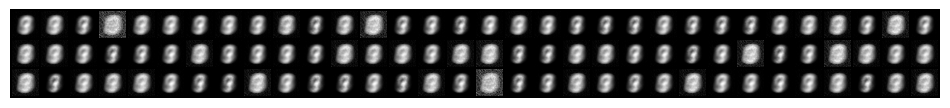

Epoch [2/10], Loss: 0.2399
------------------------------------------------------------


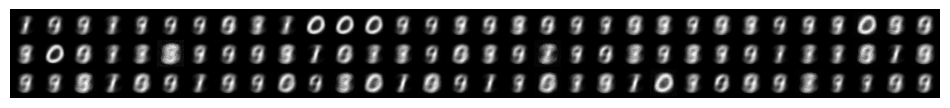

Epoch [3/10], Loss: 0.2138
------------------------------------------------------------


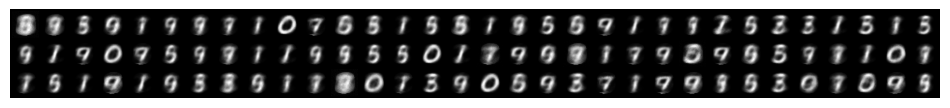

Epoch [4/10], Loss: 0.2014
------------------------------------------------------------


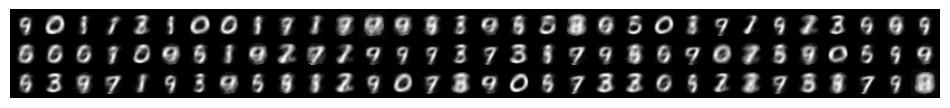

Epoch [5/10], Loss: 0.1929
------------------------------------------------------------


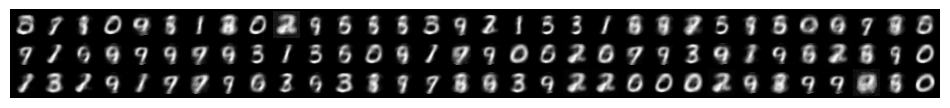

Epoch [6/10], Loss: 0.1870
------------------------------------------------------------


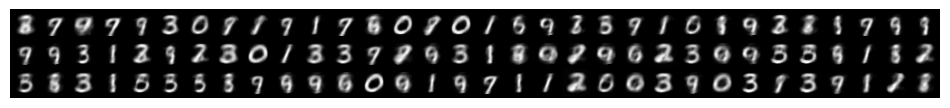

Epoch [7/10], Loss: 0.1823
------------------------------------------------------------


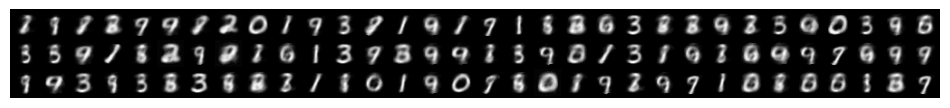

Epoch [8/10], Loss: 0.1786
------------------------------------------------------------


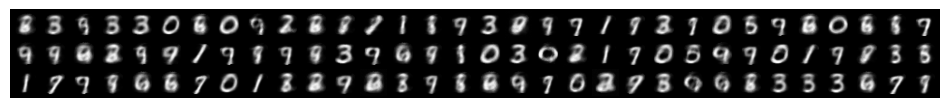

Epoch [9/10], Loss: 0.1754
------------------------------------------------------------


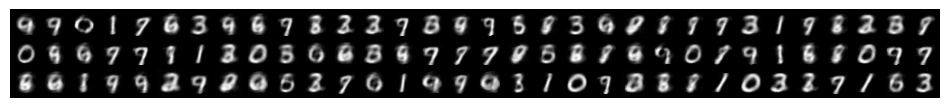

Epoch [10/10], Loss: 0.1726
------------------------------------------------------------


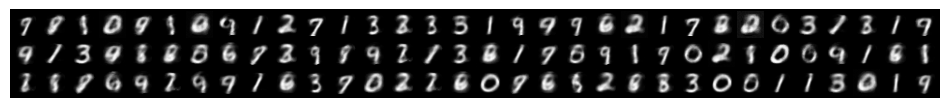

Training complete in 2m 31s


In [14]:
m = train(ae, optimizer, criterion, data_loader, 10)

The more epochs that pass, the clearer the images become as the model continues to learn.

# Conv AutoEncoder model

In [0]:
class ConvAutoEncoder(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1,16,(3,3),stride=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(16,8,(3,3), stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=1)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8,16,(3,3), stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16,8,(5,5), stride=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x    

In [16]:
conv_ae = ConvAutoEncoder()
conv_ae

ConvAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(16, 8, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(8, 1, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (5): Tanh()
  )
)

In [17]:
# text model
conv_ae(torch.rand(1, 1, 28, 28))

tensor([[[[0.1945, 0.2006, 0.1954, 0.2021, 0.1962, 0.2001, 0.1938, 0.2008,
           0.1955, 0.2022, 0.1963, 0.2010, 0.1947, 0.2002, 0.1950, 0.2021,
           0.1959, 0.2003, 0.1942, 0.2006, 0.1954, 0.2025, 0.1965, 0.2000,
           0.1935, 0.2007, 0.1954, 0.2046],
          [0.2059, 0.1527, 0.2072, 0.1461, 0.2097, 0.1474, 0.2086, 0.1526,
           0.2073, 0.1458, 0.2099, 0.1505, 0.2070, 0.1524, 0.2071, 0.1457,
           0.2102, 0.1471, 0.2083, 0.1526, 0.2075, 0.1463, 0.2093, 0.1480,
           0.2085, 0.1529, 0.2076, 0.1501],
          [0.1937, 0.2020, 0.1963, 0.2033, 0.1962, 0.2022, 0.1953, 0.2021,
           0.1965, 0.2036, 0.1965, 0.2020, 0.1959, 0.2019, 0.1962, 0.2038,
           0.1967, 0.2022, 0.1954, 0.2024, 0.1968, 0.2031, 0.1961, 0.2019,
           0.1951, 0.2021, 0.1964, 0.2017],
          [0.1987, 0.1499, 0.2060, 0.1526, 0.2088, 0.1508, 0.1966, 0.1496,
           0.2052, 0.1520, 0.2088, 0.1503, 0.1970, 0.1496, 0.2058, 0.1514,
           0.2081, 0.1511, 0.1971, 0.1503, 

In [0]:
conv_ae = ConvAutoEncoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(conv_ae.parameters(), lr=learning_rate, weight_decay=1e-5)

Epoch [1/10], Loss: 0.5587
------------------------------------------------------------


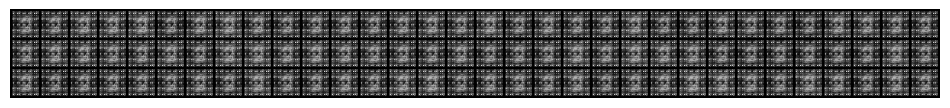

Epoch [2/10], Loss: 0.3296
------------------------------------------------------------


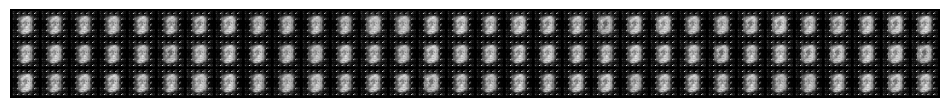

Epoch [3/10], Loss: 0.2693
------------------------------------------------------------


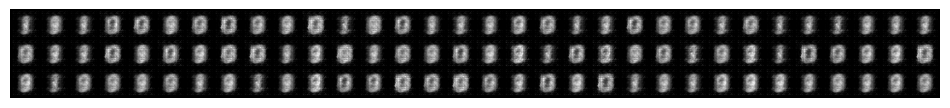

Epoch [4/10], Loss: 0.2434
------------------------------------------------------------


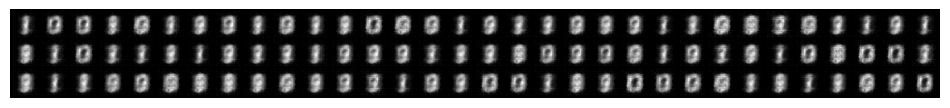

Epoch [5/10], Loss: 0.2338
------------------------------------------------------------


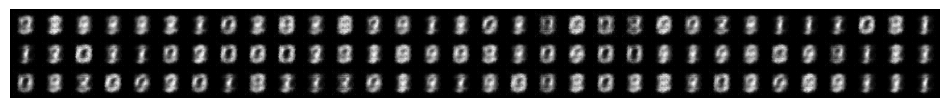

Epoch [6/10], Loss: 0.2233
------------------------------------------------------------


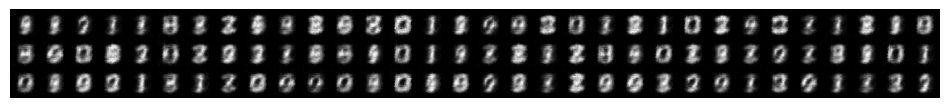

Epoch [7/10], Loss: 0.2156
------------------------------------------------------------


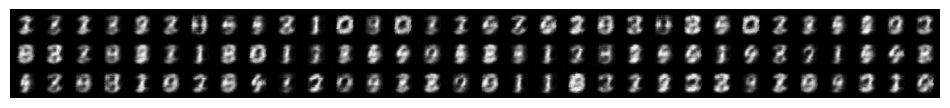

Epoch [8/10], Loss: 0.2092
------------------------------------------------------------


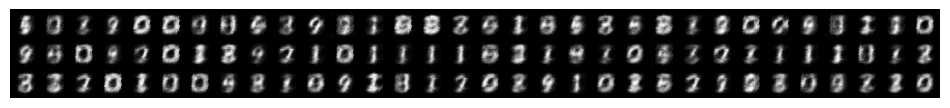

Epoch [9/10], Loss: 0.2037
------------------------------------------------------------


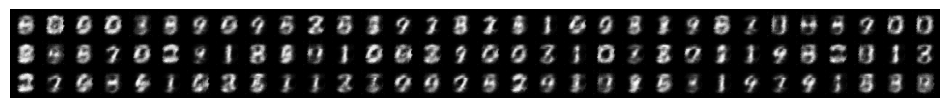

Epoch [10/10], Loss: 0.1993
------------------------------------------------------------


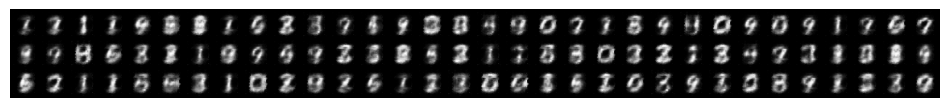

Training complete in 2m 27s


In [19]:
conv = train(conv_ae, optimizer, criterion, data_loader, 10, flatten=False)

The more epochs that pass, the clearer the images become as the model continues to learn.